# **Clustering de empresas de cr√©dito ativo**

O objetivo do projeto √© explorar uma base de dados relacionada a cr√©ditos ativos de clientes com o intuito de identificar padr√µes, perfils e poss√≠veis insights financeiros a partir dessas informa√ß√µes dispon√≠veis.

# Clustering com DBSCAN

O DBSCAN √© um algoritmo baseado em densidade utilizado para identificar grupos de dados com alta densidade. Seus componentes principais s√£o:


1.   Parametro do algoritmo:




*   eps: Raio m√°ximo para definir a vizinhan√ßa de um ponto.
*   min samples:N√∫mero m√≠nimo de pontos necess√°rios (incluindo o ponto central) para que uma regi√£o seja considerada densa.



2.   Tipo de pontos



*   Pontos centrais: Um ponto com pelo menos min_samples (vizinhos) em sua vizinhan√ßa (eps)
*   Pontos de borda: Pontos que est√£o na vizinhan√ßa mas n√£o s√£o densos o suficiente para serem pontos centrais s√£o marcados como um ponto central.
*   Ruidos: Pontos que n√£o pertencem a nenhum cluster.



**3.   Inicializa√ß√£o:**


*   Come√ßa com um ponto n√£o visitado e verifica sua vizinhan√ßa dentro do raio eps.
*   Se tem um ponto tem pelo menosvizinhos ele √© marcado como um ponto central e um novo cluster √© iniciado.


*   Todos os pontos em suas vizinhan√ßas s√£o adcionadosao cluster, e esse processo √© repetido recursivamente para todos os vizinhos centrais at√© que todos os pontos conectados densamente sejam identificados.












In [1]:
import pandas as pd
import duckdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [2]:
# Caminho do arquivo (ajustar conforme necess√°rio)
file_path = '/content/creditos-ativos-estados-municipios (version 1).xlsx'

# Verifique se o arquivo existe antes de carreg√°-lo
import os

if os.path.exists(file_path):
    excel_data = pd.ExcelFile(file_path)
    print(excel_data.sheet_names)
    df = excel_data.parse('creditos-ativos-estados-municip')
    print(df.head())
else:
    print(f"Arquivo {file_path} n√£o encontrado.")


['creditos-ativos-estados-municip']
   mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0          202401  MUNIC√çPIO       27174135000120                ES   
1          202401  MUNIC√çPIO        7165549000185                PI   
2          202401  MUNIC√çPIO       25061789000111                TO   
3          202401  MUNIC√çPIO       13692033000191                BA   
4          202401  MUNIC√çPIO       44518405000191                SP   

  tipo_vinculo  qtde_entes situacao_debito  \
0    PRINCIPAL           1   SUSP_PROC_ADM   
1    PRINCIPAL           1         DEVEDOR   
2    PRINCIPAL           1         DEVEDOR   
3    PRINCIPAL           1   SUSP_PROC_ADM   
4    PRINCIPAL           1       PARCELADO   

                              tributo  vlr_principal   vlr_multa   vlr_juros  \
0                         19 - MULTAS           0.00     2656.61      751.82   
1  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS      274894.35    50214.28    24768.97   
2  27 - CONT

In [3]:
display(df)

mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0               202401  MUNIC√çPIO       27174135000120                ES   
1               202401  MUNIC√çPIO        7165549000185                PI   
2               202401  MUNIC√çPIO       25061789000111                TO   
3               202401  MUNIC√çPIO       13692033000191                BA   
4               202401  MUNIC√çPIO       44518405000191                SP   
...                ...        ...                  ...               ...   
197311          202411  MUNIC√çPIO       33262536000134                TO   
197312          202411  MUNIC√çPIO        6554018000111                PI   
197313          202411  MUNIC√çPIO        3501566000195                MS   
197314          202411  MUNIC√çPIO       18303172000108                MG   
197315          202411  MUNIC√çPIO       13646740000141                BA   

       tipo_vinculo  qtde_entes situacao_debito  \
0         PRINCIPAL           1   SUSP_PROC_ADM   
1         PRINCIPAL           1         DEVEDOR   
2         PRINCIPAL           1         DEVEDOR   
3         PRINCIPAL           1   SUSP_PROC_ADM   
4         PRINCIPAL           1       PARCELADO   
...             ...         ...             ...   
197311    PRINCIPAL           1       PARCELADO   
197312    PRINCIPAL           1         DEVEDOR   
197313    PRINCIPAL           1   SUSP_PROC_ADM   
197314    VINCULADO           1         DEVEDOR   
197315    PRINCIPAL           1       PARCELADO   

                                   tributo  vlr_principal   vlr_multa  \
0                              19 - MULTAS           0.00     2656.61   
1       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS      274894.35    50214.28   
2       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS     4904908.09  3284519.95   
3                              19 - MULTAS           0.00     1721.40   
4                              19 - MULTAS       14047.36        0.00   
...                                    ...            ...         ...   
197311  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS     1004113.55        0.00   
197312  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS        7868.92      337.57   
197313                         19 - MULTAS           0.00     5756.67   
197314  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS        5681.64     1136.32   
197315                         19 - MULTAS          29.72        0.00   

         vlr_juros   vlr_total  
0           751.82     3408.43  
1         24768.97   349877.60  
2       1420738.34  9610166.38  
3             0.00     1721.40  
4          4455.68    18503.04  
...            ...         ...  
197311   739084.52  1743198.07  
197312       78.68     8285.17  
197313     1220.82     6977.49  
197314      251.69     7069.65  
197315       17.87       47.59  

[197316 rows x 12 columns]

**Dicion√°rio da base**

**mes_referencia:** Representa o m√™s e o ano de refer√™ncia da base de dados no formato YYYYMM.


**tipo_ente:** Descri√ß√£o: Tipo de ente p√∫blico relacionado √† opera√ß√£o de cr√©dito.


**cnpj_ente_principal:** N√∫mero do CNPJ do ente principal respons√°vel pelo cr√©dito.


**uf_ente_principal:** Unidade Federativa (UF) onde o ente principal est√° localizado.


**tipo_vinculo**: Rela√ß√£o do ente com a opera√ß√£o de cr√©dito, podendo ser principal ou secund√°ria.


**qtde_entes**: Quantidade de entes envolvidos na opera√ß√£o de cr√©dito.


**situacao_debito**: Situa√ß√£o atual do d√©bito.


**tributo**: Tipo de tributo relacionado √† opera√ß√£o de cr√©dito.

**vlr_principal**: Valor principal do d√©bito em reais (R$).

**vlr_multa** : Valor da multa associada ao d√©bito em reais (R$).

**vlr_juros**: Valor dos juros incidentes sobre o d√©bito em reais (R$).

**vlr_total**: Soma do valor principal, multa e juros, representando o valor total do d√©bito em reais (R$).

# O projeto

**1. Segmentar munic√≠pios e estados:**

‚Ä¢ Criar agrupamentos que refletem caracter√≠sticas semelhantes, considerando vari√°veis financeiras como valores de d√©bito principal, multas, juros e totais.

‚Ä¢ Avaliar diferen√ßas entre grupos de entes p√∫blicos em rela√ß√£o √†s suas situa√ß√µes de d√©bito e tributos.

**2. Identificar perfis financeiros:**

‚Ä¢ Detectar munic√≠pios ou estados com comportamentos financeiros discrepantes ou fora do padr√£o (outliers), como altos valores de d√©bito ou concentra√ß√£o em categorias espec√≠ficas de tributos.

**3. Analisar oportunidades de atua√ß√£o:**

‚Ä¢ Auxiliar na identifica√ß√£o de clusters que possam indicar regi√µes priorit√°rias para a√ß√µes de gest√£o financeira, renegocia√ß√£o de d√≠vidas ou interven√ß√µes administrativas.

**4. Demonstrar a efic√°cia de t√©cnicas de clustering:**

‚Ä¢ Comparar a aplica√ß√£o do DBSCAN com abordagens estat√≠sticas tradicionais, destacando como m√©todos baseados em densidade podem ser √∫teis para entender bases de dados com poucos atributos e limita√ß√µes temporais.



**Contexto e Justificativa**



A base de dados apresenta informa√ß√µes limitadas ao ano de 2024 e possui um n√∫mero reduzido de vari√°veis. Isso torna desafiador aplicar an√°lises explorat√≥rias tradicionais para identificar padr√µes mais profundos. O uso do DBSCAN √© justificado porque:


‚Ä¢ Permite identificar agrupamentos naturais sem a necessidade de especificar o n√∫mero de clusters previamente.

‚Ä¢ Detecta pontos de ru√≠do e outliers, o que √© relevante em contextos financeiros para identificar poss√≠veis exce√ß√µes que demandam aten√ß√£o especial.

# Criando novas features com a engenharia de features

# Criando propor√ß√µes financeiras:

Essas vari√°veis podem ajudar a entender a composi√ß√£o dos valores financeiros

**percentual_multa** = vlr_multa / vlr_total: Percentual de multa em rela√ß√£o ao total.

**percentual_juros** = vlr_juros / vlr_total: Percentual de juros em rela√ß√£o ao total.

**percentual_principal** = vlr_principal / vlr_total: Percentual do valor principal no total.

In [4]:
# Propor√ß√µes financeiras
df['percentual_multa'] = df['vlr_multa'] / df['vlr_total']
df['percentual_juros'] = df['vlr_juros'] / df['vlr_total']
df['percentual_principal'] = df['vlr_principal'] / df['vlr_total']

# Criando a vari√°vel de risco financeiro:

Vamos primeiro explorar a distribui√ß√£o da vari√°vel vlr_total que usaremos para criar uma feature de risco financeiro.

Para determinarmos as faixas para a cria√ß√£o de um score estat√≠stico devemos antes explorar sua distribui√ß√£o na base.

**. Explorar a Distribui√ß√£o**

**Por qu√™?**

Entender como os valores est√£o distribu√≠dos ajuda a identificar:


*   Padr√µes gerais: concentra√ß√£o em faixas espec√≠ficas.
*   Outliers: valores muito altos ou baixos que podem distorcer a an√°lise.
*   Assimetria: se os valores est√£o uniformemente distribu√≠dos ou concentrados em uma extremidade (ex.: cauda longa).
* Identificar pontos de corte para categorizar ou segmentar os dados.


**2. Calcular Estat√≠sticas Descritivas**

**Por qu√™?**


* As medidas descritivas fornecem uma vis√£o resumida da centralidade (m√©dia, mediana) e dispers√£o (desvio padr√£o, IQR).
* Percentis ajudam a definir faixas ou limites, como categorias de risco ou de desempenho.


**Benef√≠cios:**

Facilita a cria√ß√£o de limites objetivos, como "alto risco" ou "baixa d√≠vida".

Permite justificar decis√µes baseadas em dados para dividir os valores em grupos estatisticamente significativos.

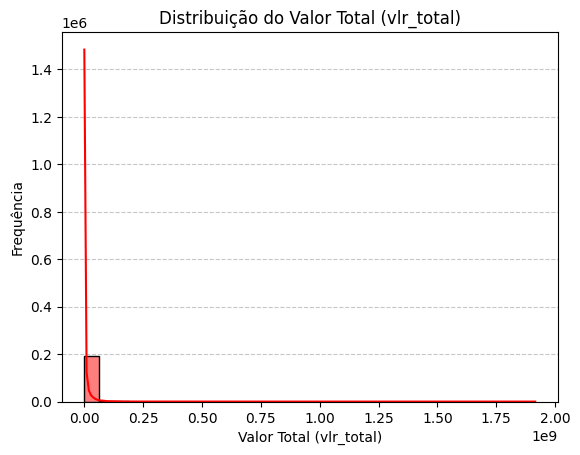

In [5]:
sns.histplot(df['vlr_total'], kde=True, bins=30, color='red')
plt.title('Distribui√ß√£o do Valor Total (vlr_total)')
plt.xlabel('Valor Total (vlr_total)')
plt.ylabel('Frequ√™ncia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

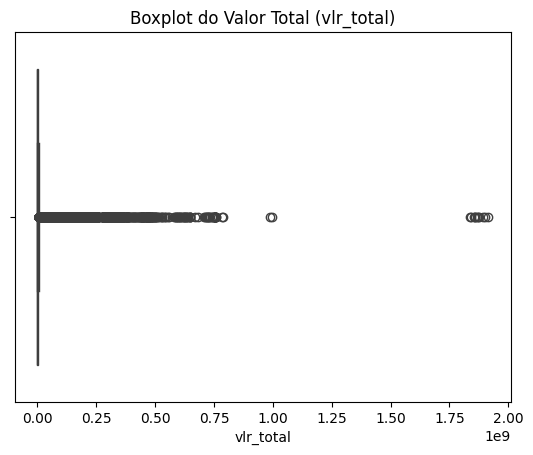

In [6]:
sns.boxplot(x=df['vlr_total'])
plt.title('Boxplot do Valor Total (vlr_total)')
plt.show()

# Assimetria (Right-Skewed)

**O que seria?**

A distribui√ß√£o √© inclinada para o lado direito, ou seja, tem uma cauda longa no lado positivo.
A maioria dos valores est√° concentrada em valores baixos, mas alguns valores extremos (outliers) puxam a distribui√ß√£o para a direita.
, assim podemos ver que amaior parte dos dados est√° concentrada em valores extremos, enquanto os valores baixos s√£o muito menos frequentes indicando uma distribui√ß√£o desbalanceada.

**Por que a assimetria √© importante nesse caso**

**Impacto nos Modelos:**

Modelos baseados em vari√¢ncia, como PCA, ou dist√¢ncias, como DBSCAN, podem ser distorcidos pela assimetria.
Valores altos (outliers) contribuem mais para a vari√¢ncia, desviando o foco dos padr√µes gerais.

**Verificando a distribui√ß√£o do DF no Geral**

‚Ä¢	Calculando o coeficiente de assimetria (right skewed) para todas as vari√°veis num√©ricas:

In [7]:
skewness = df.skew(numeric_only=True)
print(skewness)

mes_referencia           0.015161
cnpj_ente_principal      1.526660
qtde_entes              10.213958
vlr_principal           26.404324
vlr_multa               19.300008
vlr_juros               29.919138
vlr_total               23.340944
percentual_multa         0.851769
percentual_juros         0.566152
percentual_principal    -0.062683
dtype: float64


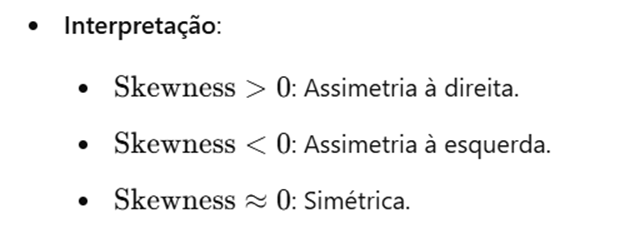

Podemos notar que v√°rias variaveis do nosso DF s√£o em sua maioria, assimetricas √† direita pois os coeficientes > 0.

In [8]:
print(df.describe())

       mes_referencia  cnpj_ente_principal     qtde_entes  vlr_principal  \
count   197316.000000         1.973160e+05  197316.000000   1.973160e+05   
mean    202405.973829         2.288655e+13       2.053959   2.973884e+06   
std          3.155583         2.541053e+13       5.819208   1.398543e+07   
min     202401.000000         7.290002e+08       1.000000   0.000000e+00   
25%     202403.000000         6.553754e+12       1.000000   0.000000e+00   
50%     202406.000000         1.311732e+13       1.000000   8.238487e+04   
75%     202409.000000         2.716569e+13       1.000000   1.266897e+06   
max     202411.000000         9.867160e+13     107.000000   9.826881e+08   

          vlr_multa     vlr_juros     vlr_total  percentual_multa  \
count  1.973160e+05  1.973160e+05  1.973160e+05     197305.000000   
mean   9.780228e+05  2.494763e+06  6.446671e+06          0.340988   
std    5.873223e+06  1.314956e+07  2.907640e+07          0.375837   
min    0.000000e+00  0.000000e+00  0.00

Vemos tamb√©m em uma das variaveis que possui assimetria √† direita que a qtde_entes, vlr_principal, vlr_multa, vlr_juros, vlr_total: S√£o vari√°veis num√©ricas, possivelmente com outliers extremos, como mostra o valor m√°ximo bem maior que o percentil 75.

Percentuais (percentual_multa, percentual_juros, percentual_principal):
Essas vari√°veis t√™m valores entre 0 e 1, o que indica que j√° est√£o escalonadas e provavelmente n√£o t√™m outliers significativos.

**Matriz de Correla√ß√£o**

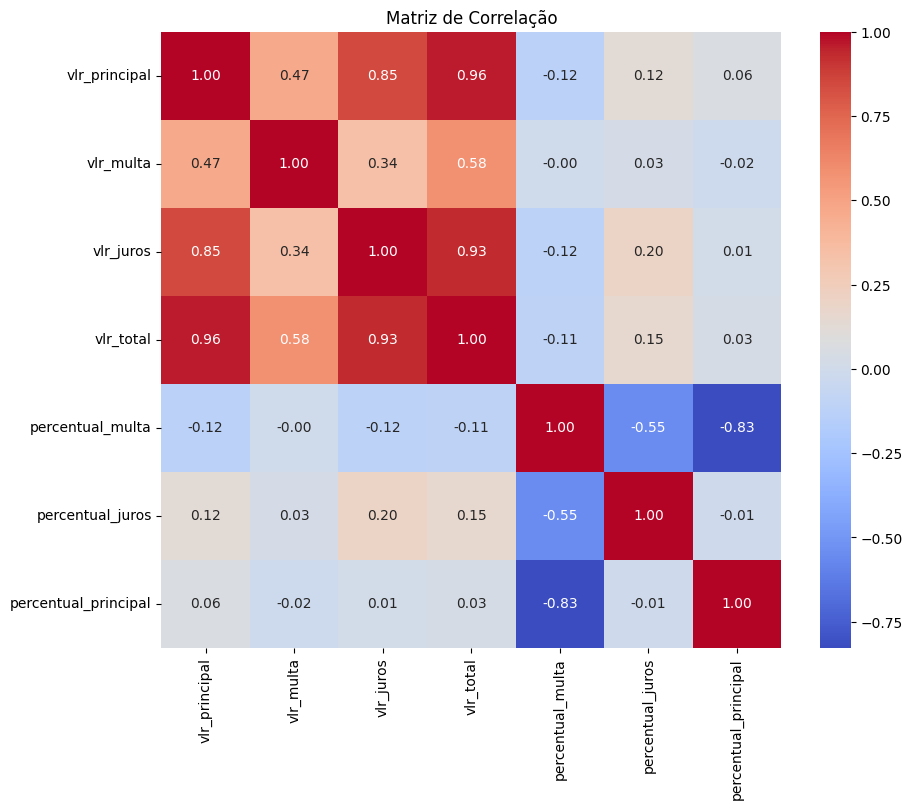

In [9]:
# Selecionar vari√°veis para an√°lise de correla√ß√£o
features = ['vlr_principal', 'vlr_multa', 'vlr_juros', 'vlr_total',
            'percentual_multa', 'percentual_juros', 'percentual_principal']

# Criar a matriz de correla√ß√£o
correlation_matrix = df[features].corr()

# Exibir a matriz de correla√ß√£o com um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correla√ß√£o")
plt.show()

##**Correla√ß√£o Altamente Positiva:**

vlr_principal, vlr_juros, e vlr_total:
Correla√ß√£o forte (>0.85>0.85), indicando que essas vari√°veis s√£o altamente redundantes.

Isso ocorre porque o vlr_total parece ser uma soma direta ou quase direta de vlr_principal, vlr_juros, e possivelmente outros componentes.

##**Impacto da Correla√ß√£o no DBSCAN**

**Redund√¢ncia:**

Vari√°veis altamente correlacionadas como vlr_principal, vlr_juros, e vlr_total podem inflar artificialmente as dist√¢ncias entre os pontos, dificultando a forma√ß√£o de clusters.

**Distor√ß√£o de Resultados:**

Vari√°veis correlacionadas podem sobrecarregar o c√°lculo de densidade, dando mais peso a informa√ß√µes repetitivas.

**Aumento da Dimensionalidade Efetiva:**

Mesmo com poucas vari√°veis, a redund√¢ncia cria um "efeito de alta dimensionalidade", onde os pontos tendem a parecer mais distantes do que realmente est√£o, prejudicando a forma√ß√£o de clusters.

# Impacto da Correla√ß√£o no DBSCAN

**Redund√¢ncia:**

*  Vari√°veis altamente correlacionadas como vlr_principal, vlr_juros, e vlr_total podem inflar artificialmente as dist√¢ncias entre os pontos, dificultando a forma√ß√£o de clusters.


**Distor√ß√£o de Resultados:**

Vari√°veis correlacionadas podem sobrecarregar o c√°lculo de densidade, dando

*  Vari√°veis correlacionadas podem sobrecarregar o c√°lculo de densidade, dando mais peso a informa√ß√µes repetitivas.

**Aumento da Dimensionalidade Efetiva:**

Mesmo com poucas vari√°veis, a redund√¢ncia cria um ‚Äúefeito de alta dimensionalidade‚Äù, onde os pontos tendem a parecer mais distantes do que realmente est√£o, prejudicando a forma√ß√£o de clusters.

# Criando uma variav√©l de Score de Cr√©dito

# **Classifica√ß√£o com Regress√£o Log√≠stica**
Para construir a base necess√°ria ao c√°lculo do score de cr√©dito, utilizamos um modelo de regress√£o log√≠stica para classificar os clientes (entes) em duas categorias principais:

Em Dia: Clientes que est√£o com seus compromissos financeiros regularizados.

Inadimplente: Clientes que possuem pend√™ncias financeiras ativas.


A regress√£o log√≠stica foi escolhida devido √† sua capacidade de estimar probabilidades para cada classe, o que nos permite n√£o apenas realizar classifica√ß√µes bin√°rias, mas tamb√©m obter um grau de confian√ßa associado a cada previs√£o.

In [10]:
# Normalizar os nomes das colunas para evitar espa√ßos ou caracteres estranhos
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Pr√©-processamento
# Tratar valores ausentes
df.fillna(0, inplace=True)

# Transformar `situacao_debito` em uma vari√°vel bin√°ria
    #1 = PARCELADO (em dia), 0 = DEVEDOR (inadimplente)
df['situacao_debito_bin'] = df['situacao_debito'].apply(lambda x: 1 if x == 'PARCELADO' else 0)

# Criar novas colunas de an√°lise
  #Realizando uma engenharia de features como fizemos acima
  #percentual_multa= vlr_multa / vlr_total: Percentual de multa em rela√ß√£o ao total.
  #percentual_juros = vlr_juros / vlr_total: Percentual de juros em rela√ß√£o ao total.
  #percentual_principal = vlr_principal / vlr_total: Percentual do valor principal no total.

df['percentual_multa'] = (df['vlr_multa'] / df['vlr_total']).fillna(0)
df['percentual_juros'] = (df['vlr_juros'] / df['vlr_total']).fillna(0)
df['percentual_principal'] = df['vlr_principal'] / df['vlr_total'].fillna(0)

# Separar vari√°veis independentes e target (bin√°ria)

X = df[['uf_ente_principal', 'tipo_ente', 'vlr_principal', 'percentual_multa', 'percentual_juros','percentual_principal']]
y = df['situacao_debito_bin']

# Configurar Pr√©-processamento
    #Definir quais colunas s√£o categ√≥ricas e quais s√£o num√©ricas
categorical_features = ['uf_ente_principal', 'tipo_ente']
numerical_features = ['vlr_principal', 'percentual_multa', 'percentual_juros', 'percentual_principal']

### Processamento ##
  # Usar ColumnTransformer para combinar transforma√ß√µes num√©ricas e categ√≥ricas
preprocessor = ColumnTransformer( #O ColumnTransformer √© usado para aplicar transforma√ß√µes espec√≠ficas em diferentes tipos de colunas
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Substituir Null pela m√©dia
            ('scaler', StandardScaler()) # Aplicar StandardScaler nas colunas num√©ricas para padroniz√°-la (z-score)
        ]), numerical_features),  #Aplicar OneHotEncoder nas colunas categ√≥ricas para transform√°-las em formato num√©rico
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features), # Aplicar StandardScaler nas colunas num√©ricas para padroniz√°-la
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Aplicar OneHotEncoder nas colunas categ√≥ricas para transform√°-las em formato num√©rico
#     ]
# )

#  Criar o Pipeline usando a sklearn.pipeline import Pipeline
     #O pipeline combina o pr√©-processamento e o modelo em um fluxo √∫nico
model_pipeline = Pipeline(steps=[ # 1 passo: pr√©-processar os dados
    ('preprocessor', preprocessor), # 2 passo: aplicar o modelo de Regress√£o Log√≠stica
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

#Divis√£o e Avalia√ß√£o com K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

# Avalia√ß√£o com valida√ß√£o cruzada
scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring=scorer)
print(f"Acur√°cia M√©dia: {np.mean(scores):.4f}")
print(f"Desvio Padr√£o das Acur√°cias: {np.std(scores):.4f}")

# Treinar o Modelo Final
model_pipeline.fit(X, y)

#Exportar o Pipeline
    #Salvar o pipeline treinado
joblib.dump(model_pipeline, 'pipeline_creditos_binario.pkl')

Acur√°cia M√©dia: 0.8932
Desvio Padr√£o das Acur√°cias: 0.0008


['pipeline_creditos_binario.pkl']

# Treinamento do Modelo:

O modelo foi treinado utilizando as vari√°veis financeiras da base de dados, como:

Valores principais de d√©bitos (vlr_principal),

Propor√ß√£o de multas e juros em rela√ß√£o ao valor total (percentual_multa e percentual_juros),

Informa√ß√µes categ√≥ricas (como o tipo do ente e a UF).


Essas vari√°veis foram pr√©-processadas com t√©cnicas como normaliza√ß√£o e codifica√ß√£o para garantir um formato adequado ao modelo.


**Previs√£o Bin√°ria:**

A regress√£o log√≠stica usa uma combina√ß√£o linear das vari√°veis preditoras e as transforma em uma probabilidade por meio da fun√ß√£o sigmoide:

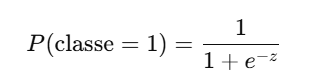

Onde
ùëß
z √© a soma ponderada das vari√°veis preditoras.


Com base nessa probabilidade, o modelo classifica o cliente:


Classe 1 (Em Dia): Quando
ùëÉ
(
Em¬†Dia
)
>
0.5
P(Em¬†Dia)>0.5.


Classe 0 (Inadimplente): Quando
ùëÉ
(
Em¬†Dia
)
‚â§
0.5
P(Em¬†Dia)‚â§0.5.


Probabilidade como Base do Score:

Al√©m da classifica√ß√£o bin√°ria, utilizamos a probabilidade gerada pelo modelo para medir a confian√ßa de que um cliente pertence √† classe "Em Dia".

Essa probabilidade √© posteriormente escalada para um intervalo de 0 a 1000, formando a base do score de cr√©dito.

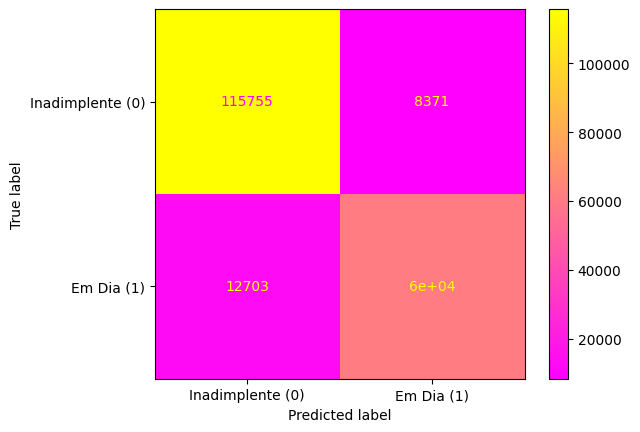

In [11]:
# Prever os valores do conjunto de dados
y_pred = model_pipeline.predict(X)

# Gerar a matriz de confus√£o
conf_matrix = confusion_matrix(y, y_pred)

# Exibir a matriz de confus√£o de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inadimplente (0)', 'Em Dia (1)'])
disp.plot(cmap='spring')


# Interpreta√ß√£o dos Valores

Verdadeiro Negativo (TN): 115,747



*   O modelo previu corretamente que 115,747 clientes estavam Inadimplentes e realmente estavam.



Falso Positivo (FP): 8,379


*   O modelo classificou 8,379 clientes como Em Dia, mas eles estavam na verdade Inadimplentes.
*   Isso pode indicar que o modelo est√° sendo um pouco "otimista" em prever que clientes est√£o em dia.



Falso Negativo (FN): 12,694


*   O modelo classificou 12,694 clientes como Inadimplentes, mas eles estavam Em Dia.
*  Esses erros podem ser cr√≠ticos, especialmente se "Em Dia" for uma classe importante para o seu neg√≥cio (por exemplo, para priorizar a√ß√µes).


Verdadeiro Positivo (TP): 60,000


*   O modelo previu corretamente que 60,000 clientes estavam Em Dia e realmente estavam.


# Criando o Score de Cr√©dito
 Construir um score de cr√©dito que possa ser integrado √† base de dados como uma nova feature, enriquecendo-a para an√°lises futuras. Esse score ser√° calculado com base no modelo de classifica√ß√£o desenvolvido, que avalia a probabilidade de um ente estar em dia com suas obriga√ß√µes financeiras.

 **Defini√ß√£o do Score:**

O score ser√° calculado a partir da probabilidade do modelo de classifica√ß√£o (regress√£o log√≠stica) prever que um ente est√° "Em Dia" (classe 1).

A probabilidade ser√° escalada para um intervalo de 0 a 1000, representando o grau de confian√ßa do modelo:



*   Score pr√≥ximo a 1000: Alta probabilidade de estar em dia.
*   Score pr√≥ximo a 0: Alta probabilidade de estar inadimplente.


**Prop√≥sito do Score**:

Representar o risco de cr√©dito de forma escal√°vel e interpret√°vel.
Integrar esse score √† base de dados como uma nova coluna, facilitando sua utiliza√ß√£o em etapas posteriores.

Para construir um score de 0 a 1000 baseado nessa classifica√ß√£o, podemos usar a probabilidade prevista pelo modelo (sa√≠da de predict_proba) como base e escal√°-la para o intervalo desejado. Essa abordagem permite que o score represente a confian√ßa do modelo de que um ente est√° "Em Dia" (classe 1).

# Como Obter as Probabilidades:

*  O m√©todo predict_proba retorna a probabilidade de cada classe para cada observa√ß√£o.

*  Vamos usar a probabilidade associada √† classe "Em Dia" (1). Item da lista


Escalar as Probabilidades para o Intervalo [0, 1000]:


*   Multiplicar a probabilidade pela escala m√°xima (1000).

Gerar o Score:

Para cada observa√ß√£o, o score ser√°:

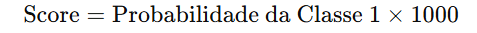

In [12]:
# Obter as probabilidades previstas pelo modelo
probabilidades = model_pipeline.predict_proba(X)

# Selecionar a probabilidade da classe 1 (Em Dia)
prob_classe_1 = probabilidades[:, 1]

# Escalar para o intervalo de 0 a 1000
score = (prob_classe_1 * 1000).astype(int)

# Criar uma c√≥pia do DataFrame original antes de adicionar a coluna
# df_resultado = df.copy()

# Adicionar o score ao DataFrame original
df['score'] = score

# Exibir algumas observa√ß√µes para verificar
print(df[['situacao_debito', 'situacao_debito_bin', 'score']].head())


  situacao_debito  situacao_debito_bin  score
0   SUSP_PROC_ADM                    0      0
1         DEVEDOR                    0    156
2         DEVEDOR                    0     37
3   SUSP_PROC_ADM                    0      0
4       PARCELADO                    1    701


In [13]:
display(df)

mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0               202401  MUNIC√çPIO       27174135000120                ES   
1               202401  MUNIC√çPIO        7165549000185                PI   
2               202401  MUNIC√çPIO       25061789000111                TO   
3               202401  MUNIC√çPIO       13692033000191                BA   
4               202401  MUNIC√çPIO       44518405000191                SP   
...                ...        ...                  ...               ...   
197311          202411  MUNIC√çPIO       33262536000134                TO   
197312          202411  MUNIC√çPIO        6554018000111                PI   
197313          202411  MUNIC√çPIO        3501566000195                MS   
197314          202411  MUNIC√çPIO       18303172000108                MG   
197315          202411  MUNIC√çPIO       13646740000141                BA   

       tipo_vinculo  qtde_entes situacao_debito  \
0         PRINCIPAL           1   SUSP_PROC_ADM   
1         PRINCIPAL           1         DEVEDOR   
2         PRINCIPAL           1         DEVEDOR   
3         PRINCIPAL           1   SUSP_PROC_ADM   
4         PRINCIPAL           1       PARCELADO   
...             ...         ...             ...   
197311    PRINCIPAL           1       PARCELADO   
197312    PRINCIPAL           1         DEVEDOR   
197313    PRINCIPAL           1   SUSP_PROC_ADM   
197314    VINCULADO           1         DEVEDOR   
197315    PRINCIPAL           1       PARCELADO   

                                   tributo  vlr_principal   vlr_multa  \
0                              19 - MULTAS           0.00     2656.61   
1       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS      274894.35    50214.28   
2       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS     4904908.09  3284519.95   
3                              19 - MULTAS           0.00     1721.40   
4                              19 - MULTAS       14047.36        0.00   
...                                    ...            ...         ...   
197311  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS     1004113.55        0.00   
197312  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS        7868.92      337.57   
197313                         19 - MULTAS           0.00     5756.67   
197314  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS        5681.64     1136.32   
197315                         19 - MULTAS          29.72        0.00   

         vlr_juros   vlr_total  percentual_multa  percentual_juros  \
0           751.82     3408.43          0.779423          0.220577   
1         24768.97   349877.60          0.143520          0.070793   
2       1420738.34  9610166.38          0.341776          0.147837   
3             0.00     1721.40          1.000000          0.000000   
4          4455.68    18503.04          0.000000          0.240808   
...            ...         ...               ...               ...   
197311   739084.52  1743198.07          0.000000          0.423982   
197312       78.68     8285.17          0.040744          0.009496   
197313     1220.82     6977.49          0.825035          0.174965   
197314      251.69     7069.65          0.160732          0.035601   
197315       17.87       47.59          0.000000          0.375499   

        percentual_principal  situacao_debito_bin  score  
0                   0.000000                    0      0  
1                   0.785687                    0    156  
2                   0.510387                    0     37  
3                   0.000000                    0      0  
4                   0.759192                    1    701  
...                      ...                  ...    ...  
197311              0.576018                    1    959  
197312              0.949760                    0    333  
197313              0.000000                    0      0  
197314              0.803666                    0    108  
197315              0.624501                    1    931  

[197316 rows x 17 columns]

# Como a Probabilidade √© Calculada?

A regress√£o log√≠stica calcula a probabilidade com base na combina√ß√£o linear das vari√°veis preditoras
ùëã
X e a aplica√ß√£o de uma fun√ß√£o sigmoide:

Passos:
C√°lculo da Combina√ß√£o Linear:

O modelo calcula uma soma ponderada das vari√°veis
ùëã
X com os coeficientes
ùë§
w: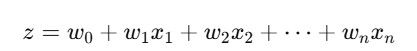

Aqui,
ùëß
z √© chamado de logit ou escore linear.
Aplica√ß√£o da Fun√ß√£o Sigmoide:

O valor
ùëß
z √© transformado em uma probabilidade com a fun√ß√£o sigmoide: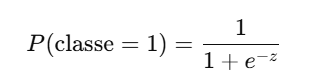

Exemplo de Fun√ß√£o Sigmoide:

Para
ùëß
=
0
z=0: Probabilidade = 0.5.


Para
ùëß
=
2
z=2: Probabilidade = 0.88.

Para
ùëß
=
‚àí
2
z=‚àí2: Probabilidade = 0.12.


O Papel do Threshold (Limiar de Decis√£o)
O modelo usa um threshold (geralmente 0.5) para converter a probabilidade em uma previs√£o de classe:

Se
ùëÉ
(
classe
=
1
)
>
0.5
P(classe=1)>0.5: Previs√£o = "Em Dia" (1).
Se
ùëÉ
(
classe
=
1
)
‚â§
0.5
P(classe=1)‚â§0.5: Previs√£o = "Inadimplente" (0).

Ajustando o Threshold:

Aumentar o threshold (e.g., 0.7) reduz os falsos positivos (FP), mas pode aumentar os falsos negativos (FN).


Diminuir o threshold (e.g., 0.3) reduz os falsos negativos, mas aumenta os falsos positivos.

# Lidando com Outiliers, Alta Dimensionalidade e vari√°veis Altamente Correlacionadas

# Outiliers


Vari√°veis financeiras (vlr_principal, vlr_multa, vlr_juros, vlr_total) possuem valores m√°ximos que s√£o muito maiores que o percentil 75.
Isso confirma que s√£o right-skewed (assim√©tricas √† direita).
lgumas vari√°veis, como vlr_total, possuem valores m√≠nimos de 0.
Zeros s√£o v√°lidos, mas podem precisar de um tratamento especial, especialmente na transforma√ß√£o logar√≠tmica


# Transforma√ß√£o Logar√≠tmica para Vari√°veis Assim√©tricas

**Como Funciona:**

O logaritmo comprime os valores √† medida que eles crescem, reduzindo a diferen√ßa entre valores pequenos e grandes.
Adicionamos
+
1
+1 para evitar problemas com
ùë•
=
0
x=0 (pois
log
‚Å°
(
0
)
log(0) √© indefinido)

In [14]:
#Criando as novas colunas transformadas e as adcionando ao DF

df['vlr_principal_log'] = np.log1p(df['vlr_principal'])
df['vlr_multa_log'] = np.log1p(df['vlr_multa'])
df['vlr_juros_log'] = np.log1p(df['vlr_juros'])
df['vlr_total_log'] = np.log1p(df['vlr_total'])


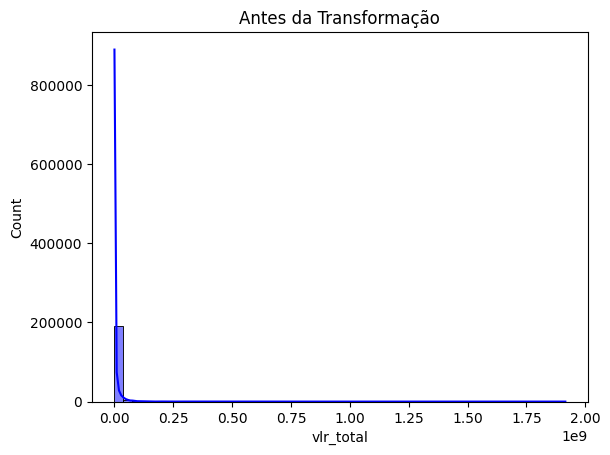

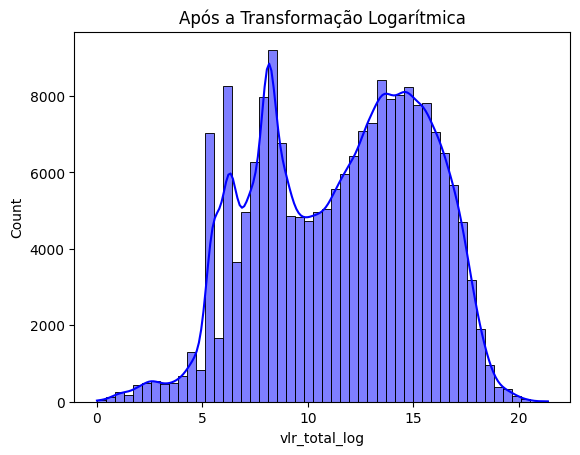

In [15]:
# Antes da transforma√ß√£o
sns.histplot(df['vlr_total'], kde=True, bins=50, color='blue')
plt.title('Antes da Transforma√ß√£o')
plt.show()

# Depois da transforma√ß√£o
sns.histplot(df['vlr_total_log'], kde=True, bins=50, color='blue')
plt.title('Ap√≥s a Transforma√ß√£o Logar√≠tmica')
plt.show()


# Aplicando as colunas transformadas pelo Log

In [16]:
#Excluir as colunas originais do DF para usarmos as novas transformadas pelo Log
df = df.drop(columns=['vlr_principal', 'vlr_multa', 'vlr_juros', 'vlr_total'])

#Visualizar o DataFrame atualizado
print(df.head())


   mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0          202401  MUNIC√çPIO       27174135000120                ES   
1          202401  MUNIC√çPIO        7165549000185                PI   
2          202401  MUNIC√çPIO       25061789000111                TO   
3          202401  MUNIC√çPIO       13692033000191                BA   
4          202401  MUNIC√çPIO       44518405000191                SP   

  tipo_vinculo  qtde_entes situacao_debito  \
0    PRINCIPAL           1   SUSP_PROC_ADM   
1    PRINCIPAL           1         DEVEDOR   
2    PRINCIPAL           1         DEVEDOR   
3    PRINCIPAL           1   SUSP_PROC_ADM   
4    PRINCIPAL           1       PARCELADO   

                              tributo  percentual_multa  percentual_juros  \
0                         19 - MULTAS          0.779423          0.220577   
1  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.143520          0.070793   
2  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.34177

# PCA
Vimos que as variaveis vlr_principal, vlr_juros, e vlr_total s√£o altamente correlacionadas, ao usar um modelo como o DBSCAN pode criar redund√¢ncia desnecess√°ria. Usando a PCA podemos combinar essas variaveis em 1 ou 2 componentes principais, que s√£o as combina√ß√µes lineares das vari√°veis originais:


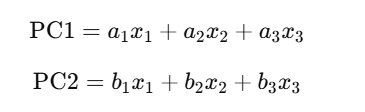


a
i
‚Äã
 ,b
i
‚Äã
 : coeficientes que determinam a contribui√ß√£o de cada vari√°vel para o componente.

A PCA combina as vari√°veis em 1 ou 2 componentes principais, reduzindo a colinearidade entre elas. Isso elimina a infla√ß√£o nas dist√¢ncias artificiais entre os pontos e minimiza redund√¢ncias, ao mesmo tempo preservando a maior parte da informa√ß√£o presente nos dados.
Em cen√°rios de alta dimensionalidade onde h√° muitas vari√°veis em rela√ß√£o ao n√∫mero de observa√ß√µes, as dist√¢ncias entre os pontos podem se tornar maiores (n√£o necessariamente correlacionadas).

Nesses casos a PCA trabalha para reduzir a dimensionalidade, simplificando os dados em componentes principais que ocupam espa√ßos menores e mais representativos



In [17]:
# Verificar os tipos de dados no DataFrame
print(df.info())

# Verificar as primeiras linhas de cada coluna para identificar valores categ√≥ricos ou n√£o num√©ricos
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197316 entries, 0 to 197315
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   mes_referencia        197316 non-null  int64  
 1   tipo_ente             197316 non-null  object 
 2   cnpj_ente_principal   197316 non-null  int64  
 3   uf_ente_principal     197316 non-null  object 
 4   tipo_vinculo          197316 non-null  object 
 5   qtde_entes            197316 non-null  int64  
 6   situacao_debito       197316 non-null  object 
 7   tributo               197316 non-null  object 
 8   percentual_multa      197316 non-null  float64
 9   percentual_juros      197316 non-null  float64
 10  percentual_principal  197305 non-null  float64
 11  situacao_debito_bin   197316 non-null  int64  
 12  score                 197316 non-null  int64  
 13  vlr_principal_log     197316 non-null  float64
 14  vlr_multa_log         197316 non-null  float64
 15  

In [18]:
# Selecionar somente colunas relevantes para a PCA, excluindo variaveis temporais, identificador num√©rico...
columns_for_pca = [
    'qtde_entes',
    #'score',
    'percentual_multa',
    'percentual_juros',
    'percentual_principal',
    'vlr_principal_log',
    'vlr_multa_log',
    'vlr_juros_log',
    'vlr_total_log'
]

# Criar DF apenas com essas colunas
df_pca = df[columns_for_pca]


In [19]:
#Substituindo valores ausentes por m√©dia
df_pca.fillna(df_pca.mean(), inplace=True)

#Padronizar as colunas com Standard
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

#Aplicar a PCA com todas as componentes
pca = PCA(n_components=len(df_pca.columns))
pca_result = pca.fit_transform(df_scaled)

<ipython-input-19-dfced793ef7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.fillna(df_pca.mean(), inplace=True)


# Vari√¢ncia na PCA

Na PCA , a vari√¢ncia √© usada para determinar quais componentes carregam mais informa√ß√µes:



1.   Cada componente principal explica uma por√ß√£o da vari√¢ncia total nos dados.
2.   A vari√¢ncia explicada ajuda a decidir quantos componentes devem ser mantidos para capturar a maior parte da informa√ß√£o.



In [20]:
# Visualizar a vari√¢ncia explicada
print("Vari√¢ncia explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("Vari√¢ncia explicada acumulada:")
print(pca.explained_variance_ratio_.cumsum())

Vari√¢ncia explicada por cada componente:
[5.28471036e-01 1.74251548e-01 1.43084102e-01 1.23517866e-01
 2.22075212e-02 6.08325877e-03 2.37638947e-03 8.27805437e-06]
Vari√¢ncia explicada acumulada:
[0.52847104 0.70272258 0.84580669 0.96932455 0.99153207 0.99761533
 0.99999172 1.        ]


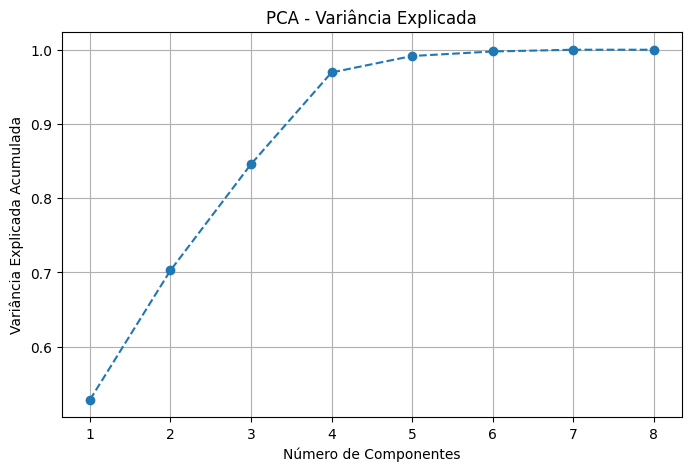

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(df_pca.columns) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Vari√¢ncia Explicada Acumulada')
plt.title('PCA - Vari√¢ncia Explicada')
plt.grid()
plt.show()


# M√©todo do Cotovelo

O m√©todo do cotovelo identifica o ponto onde a curva come√ßa a se achatar (o "cotovelo"), indicando que componentes adicionais explicam apenas alguns incrementos m√≠nimos da vari√¢ncia e n√£o s√£o t√£o significativos assim.

**Ponto antes do achatamento:** Este √© o n√∫mero ideal de componentes principais porque inclui a maior parte da informa√ß√£o relevante, sem incluir componentes redundantes ou desnecess√°rios

**Com base na an√°lise vamos reduzir o n√∫mero de componentes para 4.**

In [22]:
#Ajustando a PCA para 4 componentes
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df_scaled)

#Verificar o formato
print(pca_result.shape)

(197316, 4)


# Combinar a PCA + Vari√°veis adicionais

In [23]:
#Selecionar as vari√°veis adicionais
variables_to_include = ['score', 'situacao_debito_bin']

#Padronizar as vari√°veis adicionais
scaler_additional = StandardScaler()
variables_scaled = scaler_additional.fit_transform(df[variables_to_include])

In [24]:
# Combinar os componentes principais da PCA com as vari√°veis adicionais
X_combinacao = np.hstack([pca_result, variables_scaled])

# Aplicando o DBSCAN

In [25]:
#Aplicar o DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_combinacao)

# Adicionar os clusters ao DF
df['cluster'] = clusters

# contagem de clusters
print(df['cluster'].value_counts())

cluster
 0      120692
 1       72207
 3         741
-1         353
 6         158
         ...  
 141         5
 206         5
 157         5
 228         5
 73          5
Name: count, Length: 241, dtype: int64


In [26]:
display(df)

mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0               202401  MUNIC√çPIO       27174135000120                ES   
1               202401  MUNIC√çPIO        7165549000185                PI   
2               202401  MUNIC√çPIO       25061789000111                TO   
3               202401  MUNIC√çPIO       13692033000191                BA   
4               202401  MUNIC√çPIO       44518405000191                SP   
...                ...        ...                  ...               ...   
197311          202411  MUNIC√çPIO       33262536000134                TO   
197312          202411  MUNIC√çPIO        6554018000111                PI   
197313          202411  MUNIC√çPIO        3501566000195                MS   
197314          202411  MUNIC√çPIO       18303172000108                MG   
197315          202411  MUNIC√çPIO       13646740000141                BA   

       tipo_vinculo  qtde_entes situacao_debito  \
0         PRINCIPAL           1   SUSP_PROC_ADM   
1         PRINCIPAL           1         DEVEDOR   
2         PRINCIPAL           1         DEVEDOR   
3         PRINCIPAL           1   SUSP_PROC_ADM   
4         PRINCIPAL           1       PARCELADO   
...             ...         ...             ...   
197311    PRINCIPAL           1       PARCELADO   
197312    PRINCIPAL           1         DEVEDOR   
197313    PRINCIPAL           1   SUSP_PROC_ADM   
197314    VINCULADO           1         DEVEDOR   
197315    PRINCIPAL           1       PARCELADO   

                                   tributo  percentual_multa  \
0                              19 - MULTAS          0.779423   
1       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.143520   
2       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.341776   
3                              19 - MULTAS          1.000000   
4                              19 - MULTAS          0.000000   
...                                    ...               ...   
197311  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.000000   
197312  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.040744   
197313                         19 - MULTAS          0.825035   
197314  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.160732   
197315                         19 - MULTAS          0.000000   

        percentual_juros  percentual_principal  situacao_debito_bin  score  \
0               0.220577              0.000000                    0      0   
1               0.070793              0.785687                    0    156   
2               0.147837              0.510387                    0     37   
3               0.000000              0.000000                    0      0   
4               0.240808              0.759192                    1    701   
...                  ...                   ...                  ...    ...   
197311          0.423982              0.576018                    1    959   
197312          0.009496              0.949760                    0    333   
197313          0.174965              0.000000                    0      0   
197314          0.035601              0.803666                    0    108   
197315          0.375499              0.624501                    1    931   

        vlr_principal_log  vlr_multa_log  vlr_juros_log  vlr_total_log  \
0                0.000000       7.885183       6.623826       8.134300   
1               12.524146      10.824075      10.117387      12.765342   
2               15.405747      15.004731      14.166688      16.078332   
3                0.000000       7.451474       0.000000       7.451474   
4                9.550261       0.000000       8.402159       9.825744   
...                   ...            ...            ...            ...   
197311          13.819617       0.000000      13.513169      14.371233   
197312           8.970803       5.824731       4.378019       9.022343   
197313           0.000000       8.658288       7.108097       8.850588   
197314     

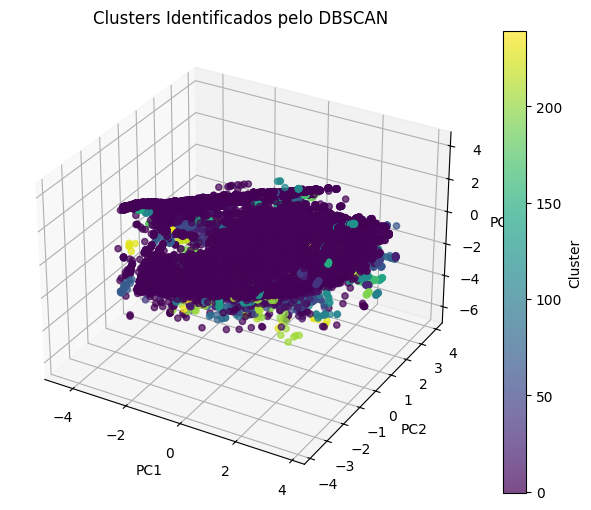

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=clusters, cmap='viridis', alpha=0.7)
ax.set_title("Clusters Identificados pelo DBSCAN")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(sc, label="Cluster")
plt.show()


# An√°lise de total de clientes por Cluster e Score

In [40]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_clientes,
    score,
    AVG(score) AS media_score,
    AVG(vlr_total_log) AS media_vlr_total_log,
    AVG(percentual_multa) AS media_percentual_multa,
    AVG(percentual_principal) AS media_percentual_principal
  FROM df
  GROUP BY cluster,score
  ORDER BY total_clientes DESC
"""
result = duckdb.query(query).to_df()
display(result)


cluster  total_clientes  score  media_score  media_vlr_total_log  \
0           0           52925      0          0.0             7.584436   
1           0             950      1          1.0            12.734543   
2           1             914    977        977.0            14.490507   
3           1             900    980        980.0            14.533743   
4           1             859    978        978.0            14.514230   
...       ...             ...    ...          ...                  ...   
4409       61               1    873        873.0            19.349203   
4410       99               1    825        825.0            13.918024   
4411      163               1    555        555.0            11.262131   
4412      225               1      5          5.0            16.224567   
4413      227               1     45         45.0            14.799844   

      media_percentual_multa  media_percentual_principal  
0                   0.928563                    0.000571  
1                   0.620004                    0.100853  
2                   0.002692                    0.401924  
3                   0.002023                    0.392353  
4                   0.002107                    0.402731  
...                      ...                         ...  
4409                0.066190                    0.271312  
4410                0.096985                    0.484924  
4411                0.000003                    0.597095  
4412                0.454056                    0.403606  
4413                0.131731                    0.713278  

[4414 rows x 7 columns]

In [28]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_registros
  FROM df
  GROUP BY cluster
  ORDER BY total_registros DESC
"""
result = duckdb.query(query).to_df()
display(result)

cluster  total_registros
0          0           120692
1          1            72207
2          3              741
3         -1              353
4          6              158
..       ...              ...
236      234                5
237       73                5
238      141                5
239      157                5
240      206                5

[241 rows x 2 columns]

# Clusters de maior Score

**Valores altos e consistentes:** Os scores est√£o acima de 896, com a maioria acima de 970 nos clusters 2,3 e 4. Isso refor√ßa que esses clientes est√£o com  um comportamento confi√°vel


Embora a maioria dos clientes seja rotulada como "DEVEDOR", **os % de multa s√£o 0** Isso pode significar que os d√©bitos est√£o sendo gerenciados de forma consistente por parte dos clientes devedores, mas ainda precisam de regulariza√ß√£o.

**% de Juros:** Valores m√©dios est√£o em torno de 0.7, indicando que juros representam uma parte significativa dos d√©bitos totais.

**% Principal:** Com valores pr√≥ximos de 0.3, o valor principal da d√≠vida √© proporcionalmente menor, o que pode refletir em uma boa capacidade de pagamento.

Algumas entradas possuem situa√ß√£o como "SUSP_PROC_JUD", o que pode indicar processos judiciais em andamento para resolver os d√©bitos. Esses clientes podem estar regularizando suas pend√™ncias.



In [44]:
query = """
  SELECT *
  FROM df
  WHERE cluster = 2 OR cluster = 3 OR cluster = 4
"""
result = duckdb.query(query).to_df()
display(result)


mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0            202401     ESTADO        5054861000176                PA   
1            202401  MUNIC√çPIO       83039842000184                SC   
2            202401  MUNIC√çPIO       87612834000136                RS   
3            202401  MUNIC√çPIO       87612990000105                RS   
4            202401  MUNIC√çPIO       16233439000102                BA   
..              ...        ...                  ...               ...   
764          202411  MUNIC√çPIO       76206606000140                PR   
765          202411  MUNIC√çPIO       46634614000126                SP   
766          202411     ESTADO       42498600000171                RJ   
767          202411  MUNIC√çPIO       16257719000142                BA   
768          202411  MUNIC√çPIO        7977044000115                CE   

    tipo_vinculo  qtde_entes situacao_debito  \
0      VINCULADO          75   SUSP_PROC_ADM   
1      PRINCIPAL           1         DEVEDOR   
2      PRINCIPAL           1         DEVEDOR   
3      PRINCIPAL           1         DEVEDOR   
4      PRINCIPAL           1   SUSP_PROC_JUD   
..           ...         ...             ...   
764    PRINCIPAL           1   SUSP_PROC_JUD   
765    VINCULADO           2   SUSP_PROC_ADM   
766    PRINCIPAL           1   SUSP_PROC_ADM   
767    PRINCIPAL           1   SUSP_PROC_JUD   
768    VINCULADO           1         DEVEDOR   

                                tributo  percentual_multa  percentual_juros  \
0    27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.716838   
1                            06 - PASEP               0.0          0.705016   
2                            06 - PASEP               0.0          0.714701   
3                            06 - PASEP               0.0          0.714825   
4    27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.306283   
..                                  ...               ...               ...   
764  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.745679   
765  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.648260   
766  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.683444   
767  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.292204   
768  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS               0.0          0.670932   

     percentual_principal  situacao_debito_bin  score  vlr_principal_log  \
0                0.283162                    0    892          12.334308   
1                0.294984                    0    979          10.452978   
2                0.285299                    0    972          11.621948   
3                0.285175                    0    972          11.526613   
4                0.693717                    0    896          13.452232   
..                    ...                  ...    ...                ...   
764              0.254321                    0    988          13.757586   
765              0.351740                    0    971          11.230993   
766              0.316556                    0    893           9.739812   
767              0.707796                    0    892          15.372602   
768              0.329068                    0    988          10.499072   

     vlr_multa_log  vlr_juros_log  vlr_total_log  cluster  
0              0.0      13.263138      13.596043        2  
1              0.0      11.324260      11.673791        3  
2              0.0      12.540271      12.876161        3  
3              0.0      12.445544      12.781260        3  
4              0.0      12.634679      13.817923        3  
..             ...            ...            ...      ...  
764            0.0      14.833282      15.126743        3  
765            0.0      11.842387      12.275848        3  
766            0.0      10.509425      10.890027        3  
767            0.0      14.487897      15.718201        3  


# Oportunidades:

Clientes nesse grupo podem estar pr√≥ximos de regularizar seus d√©bitos, podem estra tentando regularizar pagando suas parcelas mesmo que ainda n√£o tenha conseguido quitar o valor total da d√≠vida.

 Estrat√©gias para finaliza√ß√£o como renegocia√ß√µes ou incentivos de regulariza√ß√£o, podem ser eficazes nesse grupo.

Clientes com status "SUSP_PROC_JUD" podem demandar aten√ß√£o especial para ajudar na conclus√£o dos processos judiciais.

# Cluster de Menor Score

**% de Multa:**

O percentual de multa varia amplamente indicando que alguns clientes possuem multas altas enquanto outros t√™m valores baixos, estes est√£o em maioria nos clusters 0 e 1 (tamb√©m presentes em outros considerados outiliers)
Um % de multa elevado pode indicar d√≠vidas penalizadas por atrasos prolongados.

**%  Principal:**

Clientes com valores expressivos no percentual principal indicam que o valor principal da d√≠vida constitui a maior parte do total.

Clientes com percentual_principal 0.0 provavelmente t√™m maior dificuldade em pagar a d√≠vida principal, j√° que a maior parte do d√©bito est√° composta de multas e juros.

**Score Baixo e Percentual de Multa Alto:**

Clientes com scores muito baixos (pr√≥ximos a 0) e percentual_multa elevado podem ser tratados com estrat√©gias de renegocia√ß√£o ou desconto de multas para incentivar o pagamento.

**Score M√©dio e % Principal elevado:**

Clientes com scores mais altos (pr√≥ximos a 99) e percentual_principal maior que 0.7 podem ser bons candidatos para programas de fideliza√ß√£o, j√° que possuem menor risco.

In [42]:
query = """
  SELECT *
  FROM df
  WHERE cluster = 0 OR cluster = 1
"""
result = duckdb.query(query).to_df()
display(result)


mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0               202401  MUNIC√çPIO       27174135000120                ES   
1               202401  MUNIC√çPIO        7165549000185                PI   
2               202401  MUNIC√çPIO       25061789000111                TO   
3               202401  MUNIC√çPIO       13692033000191                BA   
4               202401  MUNIC√çPIO        2133098000180                TO   
...                ...        ...                  ...               ...   
192894          202411  MUNIC√çPIO        1612650000150                PB   
192895          202411  MUNIC√çPIO       18244319000128                MG   
192896          202411  MUNIC√çPIO        6554018000111                PI   
192897          202411  MUNIC√çPIO        3501566000195                MS   
192898          202411  MUNIC√çPIO       18303172000108                MG   

       tipo_vinculo  qtde_entes situacao_debito  \
0         PRINCIPAL           1   SUSP_PROC_ADM   
1         PRINCIPAL           1         DEVEDOR   
2         PRINCIPAL           1         DEVEDOR   
3         PRINCIPAL           1   SUSP_PROC_ADM   
4         PRINCIPAL           1   SUSP_PROC_ADM   
...             ...         ...             ...   
192894    PRINCIPAL           1         DEVEDOR   
192895    VINCULADO           2         DEVEDOR   
192896    PRINCIPAL           1         DEVEDOR   
192897    PRINCIPAL           1   SUSP_PROC_ADM   
192898    VINCULADO           1         DEVEDOR   

                                   tributo  percentual_multa  \
0                              19 - MULTAS          0.779423   
1       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.143520   
2       27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.341776   
3                              19 - MULTAS          1.000000   
4                               06 - PASEP          0.249233   
...                                    ...               ...   
192894  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.155687   
192895                         19 - MULTAS          0.762452   
192896  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.040744   
192897                         19 - MULTAS          0.825035   
192898  27 - CONTRIBUI√á√ïES PREVIDENCI√ÅRIAS          0.160732   

        percentual_juros  percentual_principal  situacao_debito_bin  score  \
0               0.220577              0.000000                    0      0   
1               0.070793              0.785687                    0    156   
2               0.147837              0.510387                    0     37   
3               0.000000              0.000000                    0      0   
4               0.418456              0.332311                    0    432   
...                  ...                   ...                  ...    ...   
192894          0.051576              0.792737                    0    170   
192895          0.237548              0.000000                    0      0   
192896          0.009496              0.949760                    0    333   
192897          0.174965              0.000000                    0      0   
192898          0.035601              0.803666                    0    108   

        vlr_principal_log  vlr_multa_log  vlr_juros_log  vlr_total_log  \
0                0.000000       7.885183       6.623826       8.134300   
1               12.524146      10.824075      10.117387      12.765342   
2               15.405747      15.004731      14.166688      16.078332   
3                0.000000       7.451474       0.000000       7.451474   
4               11.857457      11.569777      12.087955      12.959136   
...                   ...            ...            ...            ...   
192894           8.327385       6.700731       5.598422       8.559599   
192895           0.000000       2.393339       1.410987       2.642622   
192896           8.970803       5.824731       4.378019       9.022343   
192897     

# An√°lise Perfil N√£o Inadimplente

**Clusters Representados:**

H√° registros em v√°rios clusters, incluindo 1 (score alto) e 155 (score baixo).
Isso sugere que, mesmo entre clientes n√£o inadimplentes h√° diferen√ßas significativas de comportamento que refletem em variabilidade nos scores.

**Log de Valores (Multa, Juros e Total):**

Alguns clientes possuem vlr_multa_log e vlr_juros_log iguais a 0, indicando que n√£o h√° multas ou juros aplicados.


**% de Multa e Principal:**

Clientes com percentual_multa pr√≥ximo de 0.0 s√£o aqueles que pagam principalmente o valor principal.

Outros clientes com percentual_multa elevado (ex.: 0.78) podem estar pagando mais multas atreladas √† d√≠vida do que o valor principal dela.

**Clientes com Baixo Score:**

Possivelmente regularizaram suas d√≠vidas mas com multas altas e valores principais reduzidos para que ficassem mais acessiveis ao pagamento atrav√©s da redu√ß√£o de taxas e descontos.

**Estrat√©gia:**
Oferecer renegocia√ß√µes para reduzir o percentual de multas e incentivar o pagamento de novos d√©bitos.

**Clientes com Alto Score**

S√£o clientes consistentes e priorit√°rios para fideliza√ß√£o.

**Estrat√©gia:**
Manter condi√ß√µes favor√°veis e acompanhar pagamentos futuros e renda para evitar inadimpl√™ncia.


**Clusters Diferentes Dentro de "PARCELADO":**

A presen√ßa de diversos clusters indica perfis distintos de clientes n√£o inadimplentes que podem ser explorados em detalhes.

Exemplo:

Cluster 155: Clientes com score baixo e percentual de multa elevado.

Cluster 1: Clientes com score alto e valores de d√≠vida elevados.

In [36]:
query = """
  SELECT
    mes_referencia,
    tipo_ente,
    cnpj_ente_principal,
    uf_ente_principal,
    tipo_vinculo,
    situacao_debito_bin,
    score,
    cluster,
    vlr_total_log,
    vlr_multa_log,
  	vlr_juros_log,
    percentual_multa,
    percentual_principal
  FROM df
  WHERE  situacao_debito_bin = '1'
  GROUP BY ALL
  ORDER BY score ASC
"""
result = duckdb.query(query).to_df()
display(result)



mes_referencia  tipo_ente  cnpj_ente_principal uf_ente_principal  \
0              202407  MUNIC√çPIO       16445843000131                BA   
1              202410  MUNIC√çPIO       16445843000131                BA   
2              202401  MUNIC√çPIO       16445843000131                BA   
3              202402  MUNIC√çPIO       16445843000131                BA   
4              202404  MUNIC√çPIO       16445843000131                BA   
...               ...        ...                  ...               ...   
73185          202402     ESTADO       18715615000160                MG   
73186          202403     ESTADO       18715615000160                MG   
73187          202404     ESTADO       18715615000160                MG   
73188          202405     ESTADO       18715615000160                MG   
73189          202406     ESTADO       18715615000160                MG   

      tipo_vinculo  situacao_debito_bin  score  cluster  vlr_total_log  \
0        PRINCIPAL                    1      0      155      13.010440   
1        PRINCIPAL                    1      0      155      12.969449   
2        PRINCIPAL                    1      0      155      13.081574   
3        PRINCIPAL                    1      0      155      13.051371   
4        PRINCIPAL                    1      0      155      13.047966   
...            ...                  ...    ...      ...            ...   
73185    PRINCIPAL                    1    999        1      21.365053   
73186    PRINCIPAL                    1    999        1      21.361063   
73187    PRINCIPAL                    1    999        1      21.352559   
73188    PRINCIPAL                    1    999        1      21.349924   
73189    PRINCIPAL                    1    999        1      21.346783   

       vlr_multa_log  vlr_juros_log  percentual_multa  percentual_principal  
0          12.724564      11.618719          0.751355              0.000000  
1          12.660026      11.645689          0.733869              0.000000  
2          12.842346      11.534014          0.787235              0.000000  
3          12.804606      11.531212          0.781324              0.000000  
4          12.785188      11.583016          0.768912              0.000000  
...              ...            ...               ...                   ...  
73185       0.000000      20.654480          0.000000              0.508638  
73186       0.000000      20.663817          0.000000              0.502046  
73187       0.000000      20.654704          0.000000              0.502348  
73188       0.000000      20.657432          0.000000              0.499672  
73189       0.000000      20.659159          0.000000              0.497230  

[73190 rows x 13 columns]

In [39]:
query = """
  SELECT
    cluster,
    COUNT(*) AS total_clientes,
    score,
    AVG(score) AS media_score,
    AVG(vlr_total_log) AS media_vlr_total_log,
    AVG(percentual_multa) AS media_percentual_multa,
    AVG(percentual_principal) AS media_percentual_principal
  FROM df
  WHERE situacao_debito_bin = '1'
  GROUP BY cluster,score
  ORDER BY total_clientes DESC
"""
result = duckdb.query(query).to_df()
display(result)


cluster  total_clientes  score  media_score  media_vlr_total_log  \
0           1             914    977        977.0            14.490507   
1           1             900    980        980.0            14.533743   
2           1             859    978        978.0            14.514230   
3           1             853    976        976.0            14.591943   
4           1             852    979        979.0            14.507090   
...       ...             ...    ...          ...                  ...   
1662      191               1    567        567.0            13.555361   
1663       17               1    502        502.0             8.939004   
1664       86               1    695        695.0            19.611764   
1665       41               1     28         28.0            13.992667   
1666      189               1    579        579.0            10.221344   

      media_percentual_multa  media_percentual_principal  
0                   0.002692                    0.401924  
1                   0.002023                    0.392353  
2                   0.002107                    0.402731  
3                   0.002553                    0.408414  
4                   0.002628                    0.397488  
...                      ...                         ...  
1662                0.166029                    0.433101  
1663                0.000000                    0.641108  
1664                0.084329                    0.527056  
1665                0.234812                    0.521804  
1666                0.000000                    0.645851  

[1667 rows x 7 columns]

# **Conclus√µes Gerais**

# **Perfil Inadimplente**


**Clientes com Score Baixo:**

**Perfil Geral:**

Est√£o regularizando d√©bitos, mas apresentam percentual de multa elevado (ex: acima de 0.75).
O percentual principal √© baixo ou inexistente (0.0), podendo sugerir que a maior parte dos valores pagos corresponde a penalidades e juros acumulados da d√≠vida original.

**Poss√≠veis Raz√µes:**

D√≠vidas acumuladas por per√≠odos prolongados antes de parcelar.
Multas e juros representam uma barreira significativa para quita√ß√£o total.

**Recomenda√ß√µes Estrat√©gicas:**

Oferecer descontos ou renegocia√ß√µes focadas em reduzir as multas e juros, incentivando o pagamento do principal.
Acompanhar de perto esses clientes para prevenir retornos √† inadimpl√™ncia.

**Clientes com Score Alto**

**Perfil Geral:**

Apresentam regularidade nos pagamentos, com percentual principal elevado (ex: acima de 0.48) e percentual de multa reduzido (ex: 0).
Predominam no cluster 1, representando clientes de menor risco financeiro.
Alguns possuem d√≠vidas totais elevadas, mas com pagamentos consistentes, como indicado pelos valores logar√≠tmicos altos (vlr_total_log > 21).
Poss√≠veis Raz√µes:

Hist√≥rico de bom comportamento financeiro, com ades√£o a parcelamentos e quita√ß√£o do principal.
Benefici√°rios de programas de renegocia√ß√£o ou acordos recentes.
Recomenda√ß√µes Estrat√©gicas:

Manter condi√ß√µes favor√°veis para fidelizar esses clientes, garantindo que continuem regularizados.
Explorar oportunidades de programas de fidelidade ou benef√≠cios para incentivar novos parcelamentos.


# **Perfil Parcelado**

**Clientes com Baixo Score:**

Est√£o regularizando suas d√≠vidas mas com multas altas e valores principais reduzidos para que ficassem mais acessiveis ao pagamento atrav√©s da redu√ß√£o de taxas e descontos e assim o cliente tendo a oportunidade de quitar

**Estrat√©gia:**
Oferecer renegocia√ß√µes para reduzir o percentual de multas e incentivar o pagamento de novos d√©bitos (podendo ser √† vista e com maiores descontos)

**Clientes com Alto Score**

S√£o clientes consistentes e priorit√°rios para fideliza√ß√£o, al√©m de possuirem um bom Score, est√£o regularizando suas d√≠vidas.

**Estrat√©gia:**
Manter condi√ß√µes favor√°veis e acompanhar pagamentos futuros e renda para evitar inadimpl√™ncia.
